# Peakfinder

## Imports

If this is your first time running this, you need to install various python packages using pip. <br>
Open the terminal, either the windows command line or the VSC terminal, and run the following commands: <br>
- pip install pandas
- pip install matplotlib
- pip install numpy
- pip install ipython
For the second notebook, you will also need the following:
- pip install seaborn
- pip install scipy.stats

In [10]:
import pandas as pd # pip install pandas       
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import defaultdict
import csv
from IPython.display import clear_output

## Configuration

In [11]:
input_dir = "2025" # folder containing folder with .CSV files; subfolders are treated as animal numbers, files within them are treated as runs

output_dir = "Output" # folder containing final results

normalize = True # adjusts all values to be positive

verbose = False  # enables more output messages which can help identify problems; will only return errors if False

excel_output = True # save results as excel files; will return CSV files if False

In [12]:
startle_offset = 1000 # we assume the mouse jolts and settles down within a second after the startle

# if there are multiple startles in one experiment, write their times as a list
startle_times = {

    # new

    "ASR_control": 10000,
    "gap_depth": 10100,
    "gap_duration_10": 10060,
    "gap_duration_20": 10070,
    "gap_duration_4": 10054,
    "gap_duration_50": 10100,
    "gap_duration_8": 10058,
    "offset_ASR": 10010,
    "offset_PPI_10": 10010,
    "offset_PPI_12": 10012,
    "offset_PPI_14": 10014,
    "offset_PPI_16": 10016,
    "offset_PPI_18": 10018,
    "offset_PPI_20": 10020,
    "offset_PPI_4": 10004,
    "offset_PPI_6": 10006,
    "offset_PPI_8": 10008,
    "offset_PPI_50": 10050,
    "tone_in_noise": 10100,
    

    # old

    "ClassicalPrePulse": 60000,
    "Control_Startle": 10000,
    
    "DEPTH_50%": [1000, 21020],
    "DEPTH_75%": [1000, 21020],

    "Gap_PrePulse": 60000,
    
    "GAP10_50interval": [1000, 21020], 
    "GAP20_50interval": [1000, 21020], 
    "GAP30_50interval": [1000, 21020],
    "GAP4_50interval": [1000, 21020],
    "GAP40_50interval": [1000, 21020],
    "ISI100_duration50": [1000, 21020],
    "ISI150_duration50": [1000, 21020],
    "ISI20_duration50": [1000, 21020],
    "ISI50_duration50": [1000, 21020],

    "NoiseOffset_10ms": 10000, 
    "NoiseOffset_12ms": 10000, 
    "NoiseOffset_14ms": 10000, 
    "NoiseOffset_4ms": 10000, 
    "NoiseOffset_6ms": 10000,
    "NoiseOffset_8ms": 10000,
    "NoiseOffset_PrePulse": 10000,
    "NORMAL_PPI_100": 970,
    "NORMAL_PPI_20": 1000,
    "NORMAL_PPI_50": 1000,
    "NORMAL_PPL": 1000,

    "OFFSET_10": [1000, 21020],
    "OFFSET_12": [1000, 21020],
    "OFFSET_14": [1000, 21020],
    "OFFSET_16": [1000, 21020],
    "OFFSET_4": [1000, 21020],
    "OFFSET_6": [1000, 21020],
    "OFFSET_8": [1000, 21020]
    } 

if verbose: print(f"Raw startle times: {startle_times}")

for key, entry in startle_times.items():
    if isinstance(entry, list):
        entry[1] = entry[1] - 2*(entry[0] + startle_offset) # correct second startle time in dual recordings


if verbose: print(f"Adjusted startle times: {startle_times}")

In [13]:
data_start = 5 # row where the data starts

experiment_column = 8   # column "Exp. No."
number_column = 18      # column "TrialNo"
name_column = 17        # column "Trial"
time_column = 19        # column "MS"
value_column = 20       # column "ValueG"

# adjust columns to be 0-indexed
experiment_column, number_column, name_column, time_column, value_column = (x - 1 for x in (experiment_column, number_column, name_column, time_column, value_column))

## Slicing

In [14]:
# Initialize a dictionary to hold the segments and one to hold the matching startles
segments = {}
startles = {}

backslash = "\\"

# Loop through the directory and subdirectories to find all CSV files
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith('.csv') or file.endswith('.CSV'):
            # Construct the full file path
            file_path = os.path.join(root, file)
                
            # Read the CSV file
            df = pd.read_csv(file_path, low_memory=False, skiprows=[0, 2])
                
            current_segment = []
            previous_trial = None

            repetition = {}
                
            segment_time = 0

            # Iterate over the rows in the dataframe
            for idx, row in df.iterrows():
                current_trial = row.iloc[name_column]

                if previous_trial is not None and current_trial != previous_trial: # make a cut behind the current row and save that as a segment
                    if previous_trial not in repetition:
                        repetition[previous_trial] = 1
                    else:
                        repetition[previous_trial] += 1
                        
                    segment_df = pd.DataFrame(current_segment)

                    if isinstance(startle_times[previous_trial], list):
                        segment_startle = startle_times[previous_trial][0]
                        segment_name = f"Animal{str(root).split(backslash)[-1]}_Run{file[:-4]}_{previous_trial}_Rep{repetition[previous_trial]}_Startle1"

                        startles[segment_name] = segment_startle

                        split_index = segment_startle + startle_offset # split one second after the first startle

                        first_half = segment_df.iloc[:split_index].copy().reset_index(drop=True)
                        second_half = segment_df.iloc[split_index:].copy().reset_index(drop=True)

                        # Reset the time (column 0) 
                        second_half[0] = second_half[0] - second_half[0].iloc[0]

                        segments[segment_name] = first_half 

                        if verbose: print(f"Processed {segment_name}.")

                        segment_startle = startle_times[previous_trial][1]
                        segment_name = f"Animal{str(root).split(backslash)[-1]}_Run{file[:-4]}_{previous_trial}_Rep{repetition[previous_trial]}_Startle2"

                        startles[segment_name] = segment_startle

                        segments[segment_name] = second_half 

                        if verbose: print(f"Processed {segment_name}.")

                    else:
                        segment_startle = startle_times[previous_trial]
                        segment_name = f"Animal{str(root).split(backslash)[-1]}_Run{file[:-4]}_{previous_trial}_Rep{repetition[previous_trial]}" 
                        segments[segment_name] = segment_df 
                        startles[segment_name] = segment_startle
                        if verbose: print(f"Processed {segment_name}.")


                    # Reset for new segment
                    current_segment = []
                    segment_time = 0


                # Append the row values to the current segment
                if normalize:
                    #current_segment.append([int(row.iloc[time_column]), float(abs(pd.to_numeric(row.iloc[value_column], errors='coerce')))])
                    current_segment.append([segment_time, float(abs(pd.to_numeric(row.iloc[value_column], errors='coerce')))])
                else:
                    #current_segment.append([int(row.iloc[time_column]), float(row.iloc[value_column])])
                    current_segment.append([segment_time, float(row.iloc[value_column])])
                
                # Proceed a step in both trial and time
                previous_trial = current_trial
                segment_time += 2

            # Save the last segment
            if current_segment:
                if previous_trial not in repetition:
                    repetition[previous_trial] = 1
                else:
                    repetition[previous_trial] += 1
                    
                segment_df = pd.DataFrame(current_segment)
                if isinstance(startle_times[previous_trial], list):
                    segment_startle = startle_times[previous_trial][0]
                    segment_name = f"Animal{str(root).split(backslash)[-1]}_Run{file[:-4]}_{previous_trial}_Rep{repetition[previous_trial]}_Startle1"

                    startles[segment_name] = segment_startle

                    split_index = segment_startle + startle_offset # split one second after the first startle

                    first_half = segment_df.iloc[:split_index].copy().reset_index(drop=True)
                    second_half = segment_df.iloc[split_index:].copy().reset_index(drop=True)

                    # Reset the time (column 0) 
                    second_half[0] = second_half[0] - second_half[0].iloc[0]

                    segments[segment_name] = first_half 

                    if verbose: print(f"Processed {segment_name}.")

                    segment_startle = startle_times[previous_trial][1]
                    segment_name = f"Animal{str(root).split(backslash)[-1]}_Run{file[:-4]}_{previous_trial}_Rep{repetition[previous_trial]}_Startle2"

                    startles[segment_name] = segment_startle

                    segments[segment_name] = second_half 

                    if verbose: print(f"Processed {segment_name}.")

                else:
                    segment_startle = startle_times[previous_trial]
                    segment_name = f"Animal{str(root).split(backslash)[-1]}_Run{file[:-4]}_{previous_trial}_Rep{repetition[previous_trial]}" 
                    segments[segment_name] = segment_df 
                    startles[segment_name] = segment_startle
                    if verbose: print(f"Processed {segment_name}.")

# Print results
clear_output(wait=False)
key_names = ', '.join(segments.keys())
length = len(segments)
if verbose: print(f"\nCreated {length} entries:\n{key_names}")

In [15]:
adjusted_segments = {}
for entry in segments:
    df = segments[entry]
    reference_time = startles[entry]  

    # Filter the data to get rows within the 1000 ms before and after the reference time
    start_time = reference_time - startle_offset
    end_time = reference_time + startle_offset

    # Filter the dataframe to include only the data within the time range
    filtered_df = df[(df.iloc[:, 0] >= start_time) & (df.iloc[:, 0] <= end_time)]

    # Adjust the time column to set the reference time to 0
    filtered_df.iloc[:, 0] = filtered_df.iloc[:, 0] - reference_time

    filtered_df.reset_index(drop=True, inplace=True) 

    adjusted_segments[entry] = filtered_df

    if verbose: print(f"Adjusted {entry}.")

## Plotting

In [16]:
def plot_segments(name, segments, startles, threshold, normalize=True, adjust=True, hard=False):
    # Prepare DataFrame
    if adjust:
        df = adjusted_segments[name]
        startle_x = 0
    else:
        df = segments[name]
        startle_x = startles[name]

    median = np.median(df[1])
    

    if hard:
        plot_threshold = threshold
    else:
        plot_threshold = threshold * median

    df = df.iloc[::2]  # Only use every n-th value for plotting

    # Plotting
    plot_title = name
    plt.figure(figsize=(8, 6))
    plt.plot(df[0], df[1], color="blue", marker="o", markersize=0)
    plt.axvline(x=startle_x, color='red', linewidth=2, linestyle='dotted', label="Startle")
    plt.axhline(y=plot_threshold, color='lime', linewidth=2, linestyle='dotted', label="Threshold")
    
    # Labeling
    plt.xlabel("Time (ms)", fontsize=12)
    plt.ylabel("ValueG", fontsize=12)
    plt.title(plot_title, fontsize=14)

    # Adjust y-ticks
    if normalize:
        y_ticks = range(0, int(df[1].max()) + 20, 20)
    else:
        y_ticks = range(int(df[1].min()) - 20, int(df[1].max()) + 20, 20)
    plt.yticks(y_ticks)

    if not adjust:
        # Set x-axis limits based on the startle position, from -1000 to +1000
        nearest_multiple_of_50 = round(startle_x / 50) * 50
        plt.xlim(nearest_multiple_of_50  - 1000, nearest_multiple_of_50  + 1000)

        ticks = plt.gca().get_xticks()  # maybe TODO: make the ACTUAL data also fit to this time window, since this is only visual
        plt.gca().set_xticks(ticks)  # Ensure we set the tick positions
        plt.gca().set_xticklabels([str(int(tick - nearest_multiple_of_50 + 1000)) for tick in ticks])
    
    # Grid, legend, and display
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend()

    plt.show()

In [17]:
example_name = 'Animal15_RunAnimal15_April16_ASR_control_Rep1'

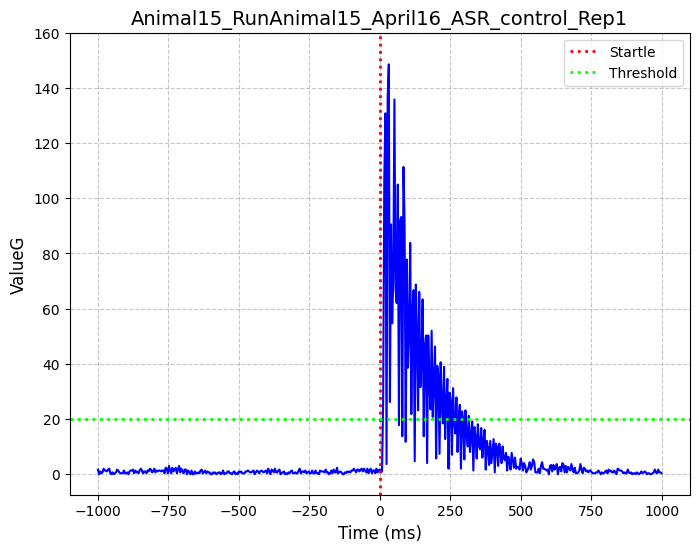

In [18]:
plot_segments(example_name, adjusted_segments, startles, threshold=15, normalize=True, adjust=True, hard=False) 

## Analysis

In [19]:
discard_low = True
discard_late = True

reaction = {}
bad_peaks = []

thresholds = [30, 25, 20, 15, 10, 5]
time_threshold = 50

hard_threshold = 5
toolow = []
toolate = []

for entry in adjusted_segments:
    x = 0  # Reset threshold index for each entry

    while x < len(thresholds):
        times = adjusted_segments[entry][0]
        values = adjusted_segments[entry][1]

        median = np.median(values)
        median_threshold = median * thresholds[x]

        indices_above_threshold = np.where((values > median_threshold) & (times > 0))[0]

        if len(indices_above_threshold) > 0:
            peak_start = times[indices_above_threshold[0]]  # First time a value passes the threshold
            start_value = values[indices_above_threshold[0]]  # First value that passes the threshold

            min_value = min(values[indices_above_threshold])  # Minimum value among those above the threshold
            min_value_index = indices_above_threshold[np.argmin(values[indices_above_threshold])]
            min_time = times[min_value_index]

            max_value = max(values[indices_above_threshold])  # Maximum value among those above the threshold
            max_value_index = indices_above_threshold[np.argmax(values[indices_above_threshold])]
            max_time = times[max_value_index]

            buildup = max_time - peak_start

            if max_value >= hard_threshold:
                if peak_start >= time_threshold:
                    toolate.append(entry)
                    if not discard_late:
                        reaction[entry] = {
                            "reactionTime": int(peak_start),
                            "peakTime": int(max_time),
                            "difference": int(buildup),
                            "strength": int(max_value)
                        }
                        if verbose: print(f"Processed {entry}.")

                reaction[entry] = {
                    "reactionTime": int(peak_start),
                    "peakTime": int(max_time),
                    "difference": int(buildup),
                    "strength": int(max_value)
                }
                if verbose: print(f"Processed {entry}.")
            else:
                toolow.append(entry)
                if not discard_low:
                    reaction[entry] = {
                        "reactionTime": int(peak_start),
                        "peakTime": int(max_time),
                        "difference": int(buildup),
                        "strength": int(max_value)
                    }
                    if verbose: print(f"Processed {entry}.")
            break

        else:
            if x == len(thresholds) - 1:  # Give up after trying the lowest threshold
                bad_peaks.append(entry)
                if verbose: print(f"No peak found for {entry} after trying all thresholds.")
                break  # Exit the loop for this entry
            else:
                if verbose: print(f"Lowering threshold for {entry}.")
                x += 1  # Try the next lower threshold

clear_output(wait=False)
reaction = {entry: data for entry, data in reaction.items() if data["reactionTime"] <= time_threshold} # remove late peaks
if verbose: print(f"Created {len(reaction)} entries.")

if bad_peaks: 
    print(f"Warning, found no peaks in {len(bad_peaks)} recordings!")
    if verbose: print(bad_peaks)
    print(f"Warning, found insignificant peaks in {len(toolow)} recordings!")
    if verbose: print(toolow)
    print(f"Warning, found late peaks in {len(toolate)} recordings!")
    if verbose: print(toolate)

Warning, found no peaks in 15 recordings!
Warning, found insignificant peaks in 14 recordings!
Warning, found late peaks in 5 recordings!


## Saving

In [20]:
# Dictionary to store grouped data by Animal + Experiment condition (ignoring startle, rep, and run)
grouped_data = defaultdict(lambda: {"reactionTime": [], "peakTime": [], "difference": [], "strength": []})

# Group entries by Animal + Experiment (removing `startleX`, `RepX`, and `RunX`)
for entry, values in reaction.items():
    parts = entry.split("_")
    animal = parts[0]  # Keep the animal identifier (e.g., "Animal25")
    
    # Remove startle, repetition, and run identifiers
    experiment = "_".join(part for part in parts[1:] if not (part.lower().startswith("startle") or part.lower().startswith("rep") or part.lower().startswith("run")))

    group_key = f"{animal}_{experiment}"  # Group by animal + experiment condition

    for key in values:
        grouped_data[group_key][key].append(values[key])

# Calculate averages for each animal's experiment condition
average_data = {
    group_key: {
        key: round(sum(val_list) / len(val_list), 2)  # Compute average and round to 2 decimals
        for key, val_list in values.items()
    }
    for group_key, values in grouped_data.items()
}

# Print the results
if verbose: print(f"Created {len(average_data)} entries.")
for key, values in average_data.items():
    if verbose: print(f"{key}: {values}")


In [21]:
# pip install openpyxl
os.makedirs(output_dir, exist_ok=True) # create output directory if not already present

grouped_data = defaultdict(list)

for entry, values in average_data.items():
    animal, experiment = entry.split("_", 1)  # Split at first underscore to separate animal from experiment
    values["experiment"] = experiment  # Add experiment name to the values dictionary
    grouped_data[animal].append(values)  # Append to the correct animal group

# Save each animal's data into a file
for animal, experiments in grouped_data.items():
    filename = f"{animal}.xlsx" if excel_output else f"{animal}.csv"
    file_path = os.path.join(output_dir, filename) 
    
    # Ensure the "Experiment" column is first
    column_order = ["experiment"] + [key for key in experiments[0] if key != "experiment"]
    
    if excel_output:
        df = pd.DataFrame(experiments, columns=column_order)
        df.to_excel(file_path, index=False)
    else:
        with open(file_path, mode="w", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=column_order)
            writer.writeheader()
            writer.writerows(experiments)

    if verbose: print(f"Saved {filename}")